##  决策树代码

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_boston
from sklearn import tree
from sklearn.model_selection import train_test_split

#分类树
X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

print ("Classifier Score:", clf.score(X_test, y_test))

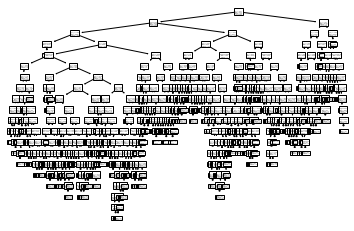

In [8]:
tree.plot_tree(clf.fit(X, y))
plt.show()

In [9]:
# 回归树
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)

print ("Regression Score:", clf.score(X_test, y_test))

Regression Score: 0.7976664001067901


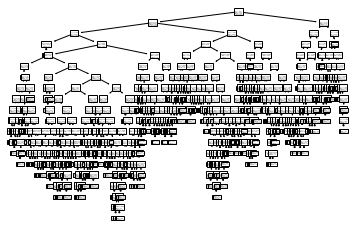

In [10]:
tree.plot_tree(clf.fit(X, y)) 
plt.show()

使用cart树的分类和回归两个接口,接口参考sklearn.

In [13]:
import copy
import numbers
import warnings
from math import ceil
from collections import Counter

import numpy as np
import pandas as pd
from scipy.sparse import issparse

In [14]:
class DecisionTree(object):
    """自定的树结构,用来保存决策树.
    
    Paramters:
    ----------
    col: int, default(-1)
        当前使用的第几列数据
    
    val: int or float or str, 分割节点
        分割节点的值, 
        int or float : 使用大于进行比较 
        str : 使用等于模式
    
    LeftChild: DecisionTree
        左子树, <= val
    
    RightChild: DecisionTree
        右子树, > val
    
    results: 
    """
    def __init__(self, col=-1, val=None, LeftChild=None, RightChild=None, result=None):
        self.col = col
        self.val = val
        self.LeftChild = LeftChild
        self.RightChild = RightChild
        self.result = result


class DecisionTreeClassifier(object):
    """使用基尼指数的分类决策树接口.
    
    Paramters:
    ---------
    max_depth : int or None, optional(dafault=None)
        表示决策树的最大深度. None: 表示不设置深度,可以任意扩展,
        直到叶子节点的个数小于min_samples_split个数.

    min_samples_split : int, optional(default=2)
        表示最小分割样例数.
        if int, 表示最小分割样例树,如果小于这个数字,不在进行分割.

    min_samples_leaf : int, optional (default=1)
        表示叶节点最少有min_samples_leaf个节点树,如果小于等于这个数,直接返回.
        if int, min_samples_leaf就是最小样例数.

    min_impurity_decrease : float, optional (default=0.)
        分割之后基尼指数大于这个数,则进行分割.
        N_t / N * (impurity - N_t_R / N_t * right_impurity
                        - N_t_L / N_t * left_impurity)

    min_impurity_split : float, default=1e-7
        停止增长的阈值,小于这个值直接返回.
    
    Attributes
    ----------
    classes_ : array of shape (n_classes,) or a list of such arrays
        表示所有的类
    
    feature_importances_ : ndarray of shape (n_features,)
        特征重要性, 被选择最优特征的次数,进行降序.
    
    tree_ : Tree object
        The underlying Tree object.
    """
    def __init__(self,
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_impurity_decrease=0.,
                 min_impurity_split=1e-7):        
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        self.classes_ = None
        self.max_features_ = None
        self.decision_tree = None
        self.all_feats = None
    
    
    def fit(self, X, y, check_input=True):
        """使用X和y训练决策树的分类模型.
        
        Parameters
        ----------
        X : {array-like} of shape (n_samples, n_features)
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32``
            
        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels) as integers or strings.
        
        check_input : bool, (default=True)
            Allow to bypass several input checking.
        
        Returns
        -------
        self : object
            Fitted estimator.
        """
        if isinstance(X, list):
            X = self.__check_array(X)
        if isinstance(y, list):
            y = self.__check_array(y)
        if X.shape[0] != y.shape[0]:
            raise ValueError("输入的数据X和y长度不匹配")
        
        self.classes_ = list(set(y))
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.DataFrame):
            y = y.values
        
        data_origin = np.c_[X, y]
#         print (data_origin)
        self.all_feats = [i for i in range(X.shape[1])]
        self.max_features_ = X.shape[0]
        
        data = copy.deepcopy(data_origin)
        self.decision_tree = self.__build_tree(data, 0)


    def __predict_one(self, input_x):
        """预测一个样例的返回结果.
        
        Paramters:
        ---------
        input_x : list or np.ndarray
            需要预测输入数据
        
        Returns:
        -------
        class : 对应的类
        """
        
        tree = self.decision_tree
        #============================= show me your code =======================
        def check_val(in_val, tree_val):
            if isinstance(tree_val, int) or isinstance(tree_val, float):
                return in_val <= tree_val
            return in_val == tree_val
        
        while tree.result is None:
            tree = tree.LeftChild if check_val(input_x[tree.col], tree.val) else tree.RightChild

        pre_y = tree.result
        #============================= show me your code =======================
        return pre_y
    
    def predict(self, test):
        """预测函数,
        
        Paramters:
        ---------
        test: {array-like} of shape (n_samples, n_features)
        
        Returns:
        result : np.array(list) 
        """
        result = []
        for i in range(len(test)):
            result.append(self.__predict_one(test[i]))
        return np.array(result)
    
    
    def score(self, vali_X, vali_y):
        """验证模型的特征,这里使用准确率.
        Parameters
        ----------
        vali_X : {array-like} of shape (n_samples, n_features)
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32``

        vali_y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels) as integers or strings.
        
        Returns:
        -------
        score : float, 预测的准确率
        """
        vali_y = np.array(vali_y)
        pre_y = self.predict(vali_X)
        pre_score = 1.0 * sum(vali_y == pre_y) / len(vali_y)
        return pre_score
    
    
    def __build_tree(self, data, depth):
        """创建决策树的主要代码
        
        Paramters:
        ---------
        data : {array-like} of shape (n_samples, n_features) + {label}
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32``
        
        depth: int, 树的深度
        
        Returns:
        -------
        DecisionTree
            
        """        
        labels = np.unique(data[:,-1])
        # 只剩下唯一的类别时,停止,返回对应类别
        if len(labels) == 1:
            return DecisionTree(result=list(labels)[0])
        
        # 遍历完所有特征时,只剩下label标签,就返回出现字数最多的类标签
        if not self.all_feats:
            return DecisionTree(result=np.argmax(np.bincount(data[:,-1].astype(int))))

        # 超过最大深度,则停止,使用出现最多的参数作为该叶子节点的类
        if self.max_depth and depth > self.max_depth:
            return DecisionTree(result=np.argmax(np.bincount(data[:,-1].astype(int))))

        # 如果剩余的样本数大于等于给定的参数 min_samples_split,
        # 则不在进行分割, 直接返回类别中最多的类,该节点作为叶子节点
        if self.min_samples_split >= data.shape[0]:
            return DecisionTree(result=np.argmax(np.bincount(data[:,-1].astype(int))))

        # 叶子节点个数小于指定参数就进行返回,叶子节点中的出现最多的类
        if self.min_samples_leaf >= data.shape[0]:
            return DecisionTree(result=np.argmax(np.bincount(data[:,-1].astype(int))))
        
        # 根据基尼指数选择每个分割的最优特征
        best_idx, best_val, min_gini = self.__getBestFeature(data)
#         print ("Current best Feature:", best_idx, best_val, min_gini)
        # 如果当前的gini指数小于指定阈值,直接返回
        if min_gini < self.min_impurity_split:
            return DecisionTree(result=np.argmax(np.bincount(data[:,-1].astype(int))))
        
        leftData, rightData = self.__splitData(data, best_idx, best_val)
        
        #============================= show me your code =======================
        leftDecisionTree = self.__build_tree(leftData, depth + 1)
        rightDecisionTree = self.__build_tree(rightData, depth + 1)
        #============================= show me your code =======================
        
        return DecisionTree(col=best_idx, val=best_val, LeftChild=leftDecisionTree, RightChild=rightDecisionTree)

    
    def __getBestFeature(self, data):
        """得到最优特征对应的列
        Paramters:
        ---------
        data: np.ndarray
            从data中选择最优特征
            
        Returns:
        -------
        bestInx, val, 最优特征的列的索引和使用的值.
        """
        best_idx = -1
        best_val = None
        min_gini = 1.0                
        # 遍历现在可以使用的特征列
        #============================= show me your code =======================
        data_len = len(data)
        portion = lambda x: len(x) / data_len 
        for f in self.all_feats:
            for v in data[:,f]:
                l, r = self.__splitData(data, f, v)
                cur_gini =  portion(l)  * self.gini(l[:,-1]) + portion(r) * self.gini(r[:,-1])

                if cur_gini < min_gini:
                    best_idx = f
                    best_val = v
                    min_gini = cur_gini
        #============================= show me your code =======================
        # 删除使用过的特征
        self.all_feats.remove(best_idx)
        
        return best_idx, best_val, min_gini
        
    
    def gini(self, labels):
        """计算基尼指数.
        
        Paramters:
        ----------
        labels: list or np.ndarray, 数据对应的类目集合.
        
        Returns: 
        -------
        gini : float ``` Gini(p) = \sum_{k=1}^{K}p_k(1-p_k)=1-\sum_{k=1}^{K}p_k^2 ```
        
        """
        #============================= show me your code =======================
        label_sets = np.array(labels)
        counter = Counter(labels)
        total_cnt = len(labels)
        gini = 1.0
        for k in counter.values():
            gini -= (k / total_cnt) ** 2
        #============================= show me your code =======================
        return gini
    
    
    def __splitData(self, data, featColumn, val):
        '''根据特征划分数据集分成左右两部分.
        Paramters:
        ---------
        data: np.ndarray, 分割的数据
        
        featColumn : int, 使用第几列的数据进行分割
        
        val : int or float or str, 分割的值
            int or float : 使用比较方式
            str : 使用相等方式
        
        Returns:
        -------
        leftData, RightData
            int or left: leftData <= val < rightData
            str : leftData = val and rightData != val
        '''
        if isinstance(val, str):
            leftData = data[data[:, featColumn] == val]
            rightData = data[data[:, featColumn] != val]
        elif isinstance(val, int) or isinstance(val, float):
            leftData = data[data[:, featColumn] <= val]
            rightData = data[data[:, featColumn] > val]
        return leftData, rightData
    
    
    def __check_array(self, X):
        """检查数据类型
        Parameters:
        ----------
        X : {array-like} of shape (n_samples, n_features)
            The training input samples.
        
        Retures
        -------
        X: {array-like} of shape (n_samples, n_features)
        """
        if isinstance(X, list):
            X = np.array(X)
        if not isinstance(X, np.ndarray) and not isinstance(X, pd.DataFrame):
            raise ValueError("输出数据不合法,目前只支持np.ndarray or pd.DataFrame")
        return X


In [15]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

if __name__ == "__main__":
    # 分类树
    X, y = load_iris(return_X_y=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf = DecisionTreeClassifier()

    clf.fit(X_train, y_train)

    print ("Classifier Score:", clf.score(X_test, y_test))

Classifier Score: 0.9666666666666667
